Datasets Project
=======

## Libraries

In [2]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import overpy
import geojsonio as gjs
import json
import ipyleaflet as ipy
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon 
from descartes import PolygonPatch 
from IPython.display import IFrame 

In [108]:
ox.config(log_console=True, use_cache=True)

## Datasets

### EEA

In [109]:
spain_grid = gpd.read_file('../Datasets/spain_grid.geojson')
spain_grid.head()

,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,geometry
0,111.845,5387.27,2.744,0.0,0.0,11.975,22174.500000,POINT (42.88560 -9.28496)
1,105.190,4304.51,2.655,0.0,0.0,12.170,21000.599609,POINT (42.92040 -9.29662)
2,111.845,5387.27,2.775,0.0,0.0,11.954,22174.500000,POINT (42.87920 -9.27014)
3,111.845,5387.27,0.942,0.0,0.0,11.968,22174.500000,POINT (42.88790 -9.27305)
4,105.190,4304.51,0.541,0.0,0.0,11.999,21000.599609,POINT (42.89660 -9.27596)


In [110]:
spain_grid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

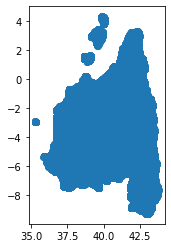

In [111]:
spain_grid.plot()

In [112]:
def swap_xy(geom):
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])
    else:
        raise ValueError('Type %r not recognized' % geom.type)

In [113]:
spain_grid.geometry = spain_grid.geometry.map(swap_xy)

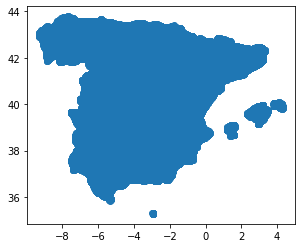

In [114]:
spain_grid.plot()

### INE Data

In [115]:
INE = gpd.read_file('../Datasets/INE_final_gpd.geojson')
INE.head()

,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Total,geometry
0,1460,760.0,695.0,170.0,930.0,360.0,1145.0,595.0,460.0,85.0,5.0,10.0,20.0,55.0,170.0,125.0,115.0,35.0,30.0,35.0,9159.0,POINT (-2.76677 37.16240)
1,1350,700.0,655.0,150.0,870.0,335.0,710.0,550.0,145.0,15.0,0.0,5.0,90.0,25.0,60.0,150.0,70.0,105.0,25.0,30.0,8827.0,POINT (-2.82616 37.13061)
2,765,325.0,445.0,70.0,590.0,105.0,405.0,295.0,20.0,95.0,0.0,0.0,0.0,0.0,140.0,100.0,0.0,0.0,0.0,0.0,8965.0,POINT (-3.01589 36.74733)
3,1750,800.0,950.0,335.0,1140.0,275.0,780.0,650.0,15.0,115.0,0.0,0.0,0.0,0.0,215.0,100.0,110.0,0.0,0.0,0.0,8599.0,POINT (-3.02153 36.74726)
4,1815,780.0,1035.0,470.0,1120.0,225.0,1100.0,610.0,40.0,450.0,0.0,0.0,0.0,60.0,250.0,160.0,65.0,0.0,0.0,0.0,8076.0,POINT (-3.00689 36.74562)


### Shapes Spain

In [116]:
shapes = gpd.read_file('../Datasets/shapes.geojson')
shapes.head()

,objectid,sum_pob_as,shape_leng,name_celda,shape__area,shape__length,geometry
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((37.64752 -0.90576, 37.64680 -0..."
1,1589,6609,176455.378779,Belalcázar y otros municipios,7.979909e+08,176455.378779,"MULTIPOLYGON (((38.65973 -4.86709, 38.65867 -4..."
2,261,5508,93715.435696,Navarrés y otros municipios,2.971162e+08,93715.435696,"MULTIPOLYGON (((39.10707 -0.66458, 39.10254 -0..."
3,1257,5161,98840.385938,Casavieja y otros municipios,3.121015e+08,98840.385938,"MULTIPOLYGON (((40.41188 -4.89526, 40.41148 -4..."
4,3178,16920,21437.000417,Palma de Mallorca (SCD Number 5-B),6.731973e+06,21437.000417,"MULTIPOLYGON (((39.54769 2.70288, 39.54661 2.7..."


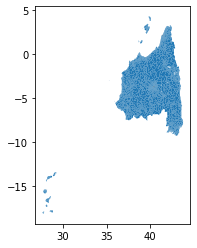

In [117]:
shapes.plot()

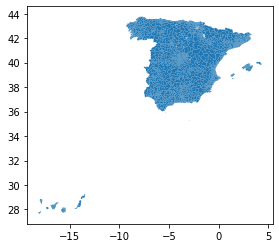

In [118]:
shapes.geometry = shapes.geometry.map(swap_xy)
shapes.plot()

In [119]:
shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Merges

We are merging by intersecting points with areas.

In [120]:
shapesVspain = gpd.sjoin(shapes, spain_grid, how="inner", op='intersects')
shapesVspain.head()

,objectid,sum_pob_as,shape_leng,name_celda,shape__area,shape__length,geometry,index_right,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",386920,124.477,8583.16,6.823,0.000,0.12342,19.827,26129.599609
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",387567,124.477,8583.16,6.863,0.000,0.08978,18.634,26129.599609
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",388215,124.274,8567.95,7.085,0.035,0.06404,17.593,26116.800781
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",386274,119.926,7714.50,7.701,0.000,0.06165,22.732,25168.199219
0,2585,11395,53268.077784,Cartagena (distrito 05),6.457586e+07,53268.077784,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",386921,124.477,8583.16,7.718,0.000,0.08045,21.927,26129.599609


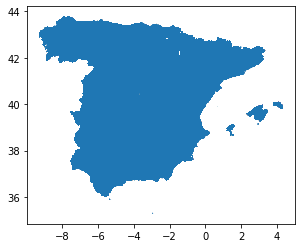

In [133]:
shapesVspain.plot()

In [135]:
x = shapesVspain.groupby('objectid').mean()
x = x.drop('index_right', axis = 1)

x.head()

,sum_pob_as,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10
objectid,,,,,,,,,,,
1,7682.0,35771.338209,5.101956e+07,35771.338210,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155
2,14354.0,63295.634626,8.100284e+07,63295.634626,125.605278,7048.907215,9.247557,0.085032,0.010408,25.948532,23777.281571
3,5071.0,120439.774794,2.772914e+08,120439.774794,125.485913,8027.057319,7.279243,0.022464,0.006684,21.436130,25515.215665
4,6756.0,262576.084345,8.967069e+08,262576.084345,118.838681,7949.650277,4.458692,0.009230,0.006449,21.537608,25481.213501
5,6218.0,18204.294363,6.805165e+06,18204.294363,118.133429,7308.860000,13.053857,0.763214,0.035393,17.339571,24372.414621


In [137]:
y = x.merge(shapesVspain[['objectid','geometry','name_celda']], left_index = True , right_on='objectid')
y.head()

,sum_pob_as,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,objectid,geometry,name_celda
1038,7682.0,35771.338209,5.101956e+07,35771.33821,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"
1038,7682.0,35771.338209,5.101956e+07,35771.33821,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"
1038,7682.0,35771.338209,5.101956e+07,35771.33821,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"
1038,7682.0,35771.338209,5.101956e+07,35771.33821,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"
1038,7682.0,35771.338209,5.101956e+07,35771.33821,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"


In [139]:
y = y.drop_duplicates()
y.head()

,sum_pob_as,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,objectid,geometry,name_celda
1038,7682.0,35771.338209,5.101956e+07,35771.338210,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,1,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa"
2052,14354.0,63295.634626,8.100284e+07,63295.634626,125.605278,7048.907215,9.247557,0.085032,0.010408,25.948532,23777.281571,2,"MULTIPOLYGON (((1.80187 41.79711, 1.80187 41.7...",Sant Joan de Vilatorrada y otros municipios
346,5071.0,120439.774794,2.772914e+08,120439.774794,125.485913,8027.057319,7.279243,0.022464,0.006684,21.436130,25515.215665,3,"MULTIPOLYGON (((-3.06791 40.15767, -3.06791 40...",Fuentidueña de Tajo y otros municipios
1483,6756.0,262576.084345,8.967069e+08,262576.084345,118.838681,7949.650277,4.458692,0.009230,0.006449,21.537608,25481.213501,4,"MULTIPOLYGON (((-5.95369 37.99535, -5.95369 37...","Real de la Jara, El y otros municipios"
1650,6218.0,18204.294363,6.805165e+06,18204.294363,118.133429,7308.860000,13.053857,0.763214,0.035393,17.339571,24372.414621,5,"MULTIPOLYGON (((-0.13299 38.96818, -0.13299 38...",Daimús y otros municipios


In [141]:
z = gpd.GeoDataFrame(y, crs="EPSG:4326", geometry='geometry')

In [142]:
pd.set_option('display.max_columns', None)

df = gpd.sjoin(z, INE, how="inner", op='intersects')
df = df.drop(['index_right','objectid'], axis = 1)

df['Total_income_x_tot_pop'] = df.tot_pop * df.Total

df.head()

,sum_pob_as,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,geometry,name_celda,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Total,Total_income_x_tot_pop
1038,7682.0,35771.338209,5.101956e+07,35771.338210,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa",1855,920.0,935.0,285.0,1265.0,310.0,1090.0,795.0,140.0,155.0,0.0,0.0,40.0,95.0,255.0,200.0,75.0,80.0,15.0,40.0,7927.0,14704585.0
1038,7682.0,35771.338209,5.101956e+07,35771.338210,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa",2995,1515.0,1480.0,385.0,1895.0,715.0,2195.0,1235.0,710.0,250.0,0.0,0.0,0.0,150.0,630.0,225.0,75.0,60.0,45.0,55.0,7681.0,23004595.0
1038,7682.0,35771.338209,5.101956e+07,35771.338210,120.717098,8101.700588,8.572569,0.094363,0.027648,17.526804,25482.455155,"MULTIPOLYGON (((-0.76203 38.07029, -0.76203 38...","Montesinos, Los y Algorfa",3310,1640.0,1670.0,400.0,2010.0,900.0,2530.0,1535.0,305.0,685.0,0.0,0.0,120.0,275.0,370.0,355.0,215.0,130.0,50.0,25.0,7478.0,24752180.0
2052,14354.0,63295.634626,8.100284e+07,63295.634626,125.605278,7048.907215,9.247557,0.085032,0.010408,25.948532,23777.281571,"MULTIPOLYGON (((1.80187 41.79711, 1.80187 41.7...",Sant Joan de Vilatorrada y otros municipios,2190,1060.0,1125.0,305.0,1550.0,330.0,1000.0,860.0,30.0,110.0,0.0,0.0,45.0,175.0,205.0,150.0,95.0,95.0,70.0,25.0,12372.0,27094680.0
2052,14354.0,63295.634626,8.100284e+07,63295.634626,125.605278,7048.907215,9.247557,0.085032,0.010408,25.948532,23777.281571,"MULTIPOLYGON (((1.80187 41.79711, 1.80187 41.7...",Sant Joan de Vilatorrada y otros municipios,2095,985.0,1110.0,490.0,1445.0,160.0,900.0,785.0,10.0,105.0,0.0,10.0,40.0,150.0,145.0,115.0,75.0,120.0,50.0,75.0,12145.0,25443775.0


In [143]:
group_df_right = df.iloc[:,12:].groupby(df.index).sum()
group_df_right.head()

,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Total,Total_income_x_tot_pop
0,8930,4695.0,4230.0,1520.0,5825.0,1585.0,4000.0,3245.0,170.0,580.0,0.0,35.0,320.0,580.0,1275.0,190.0,35.0,45.0,0.0,15.0,53290.0,60999510.0
1,6285,3090.0,3190.0,810.0,3675.0,1800.0,4370.0,2545.0,1105.0,720.0,0.0,20.0,90.0,205.0,760.0,445.0,385.0,290.0,55.0,125.0,65260.0,51153600.0
2,5885,3010.0,2880.0,840.0,3770.0,1285.0,4055.0,2375.0,595.0,1085.0,0.0,20.0,125.0,115.0,585.0,345.0,365.0,405.0,170.0,245.0,44923.0,52442820.0
3,5740,3050.0,2700.0,580.0,3245.0,1925.0,8565.0,2595.0,5210.0,760.0,35.0,160.0,365.0,465.0,705.0,355.0,185.0,180.0,80.0,55.0,71158.0,48583050.0
4,17260,9020.0,8235.0,2920.0,12130.0,2210.0,9425.0,7335.0,955.0,1120.0,0.0,240.0,900.0,1195.0,1980.0,975.0,490.0,170.0,40.0,85.0,107342.0,211202415.0


Creating Income as total income of an area per population of that area.

In [144]:
group_df_right['Income'] = group_df_right.Total_income_x_tot_pop/group_df_right.tot_pop
group_df_right = group_df_right.drop('Total_income_x_tot_pop', axis = 1)

In [145]:
group_df_right.head()

,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Total,Income
0,8930,4695.0,4230.0,1520.0,5825.0,1585.0,4000.0,3245.0,170.0,580.0,0.0,35.0,320.0,580.0,1275.0,190.0,35.0,45.0,0.0,15.0,53290.0,6830.852184
1,6285,3090.0,3190.0,810.0,3675.0,1800.0,4370.0,2545.0,1105.0,720.0,0.0,20.0,90.0,205.0,760.0,445.0,385.0,290.0,55.0,125.0,65260.0,8138.997613
2,5885,3010.0,2880.0,840.0,3770.0,1285.0,4055.0,2375.0,595.0,1085.0,0.0,20.0,125.0,115.0,585.0,345.0,365.0,405.0,170.0,245.0,44923.0,8911.269329
3,5740,3050.0,2700.0,580.0,3245.0,1925.0,8565.0,2595.0,5210.0,760.0,35.0,160.0,365.0,465.0,705.0,355.0,185.0,180.0,80.0,55.0,71158.0,8463.945993
4,17260,9020.0,8235.0,2920.0,12130.0,2210.0,9425.0,7335.0,955.0,1120.0,0.0,240.0,900.0,1195.0,1980.0,975.0,490.0,170.0,40.0,85.0,107342.0,12236.524623


In [146]:
group_df_left = df.iloc[:,:13].groupby(df.index).mean()
group_df_left.head()

,sum_pob_as,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10
0,11395.0,53268.077784,6.457586e+07,53268.077784,123.945625,8542.565937,8.057984,0.115195,0.033375,18.244891,26102.251343
1,6609.0,176455.378779,7.979909e+08,176455.378779,119.989637,7825.892713,6.122181,0.006209,0.004144,24.218680,24994.937778
2,5508.0,93715.435696,2.971162e+08,93715.435696,118.637381,7915.287211,3.331214,0.011616,0.000000,12.670469,25397.019438
3,5161.0,98840.385938,3.121015e+08,98840.385938,117.125316,7001.497636,3.114153,0.025687,0.009524,20.451901,24468.385733
4,16920.0,21437.000417,6.731973e+06,21437.000417,108.150000,6171.693333,13.050167,0.902500,0.056932,22.012667,22980.366862


In [147]:
group_df = group_df_left.merge(group_df_right, left_index = True , right_index = True)
group_df = group_df.drop(['sum_pob_as', 'Total'], axis = 1)
group_df.head()

,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Income
0,53268.077784,6.457586e+07,53268.077784,123.945625,8542.565937,8.057984,0.115195,0.033375,18.244891,26102.251343,8930,4695.0,4230.0,1520.0,5825.0,1585.0,4000.0,3245.0,170.0,580.0,0.0,35.0,320.0,580.0,1275.0,190.0,35.0,45.0,0.0,15.0,6830.852184
1,176455.378779,7.979909e+08,176455.378779,119.989637,7825.892713,6.122181,0.006209,0.004144,24.218680,24994.937778,6285,3090.0,3190.0,810.0,3675.0,1800.0,4370.0,2545.0,1105.0,720.0,0.0,20.0,90.0,205.0,760.0,445.0,385.0,290.0,55.0,125.0,8138.997613
2,93715.435696,2.971162e+08,93715.435696,118.637381,7915.287211,3.331214,0.011616,0.000000,12.670469,25397.019438,5885,3010.0,2880.0,840.0,3770.0,1285.0,4055.0,2375.0,595.0,1085.0,0.0,20.0,125.0,115.0,585.0,345.0,365.0,405.0,170.0,245.0,8911.269329
3,98840.385938,3.121015e+08,98840.385938,117.125316,7001.497636,3.114153,0.025687,0.009524,20.451901,24468.385733,5740,3050.0,2700.0,580.0,3245.0,1925.0,8565.0,2595.0,5210.0,760.0,35.0,160.0,365.0,465.0,705.0,355.0,185.0,180.0,80.0,55.0,8463.945993
4,21437.000417,6.731973e+06,21437.000417,108.150000,6171.693333,13.050167,0.902500,0.056932,22.012667,22980.366862,17260,9020.0,8235.0,2920.0,12130.0,2210.0,9425.0,7335.0,955.0,1120.0,0.0,240.0,900.0,1195.0,1980.0,975.0,490.0,170.0,40.0,85.0,12236.524623


In [148]:
final = group_df.merge(df[['geometry','name_celda']], left_index = True , right_index = True)
final = final.drop_duplicates()
final.head()

,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Income,geometry,name_celda
0,53268.077784,6.457586e+07,53268.077784,123.945625,8542.565937,8.057984,0.115195,0.033375,18.244891,26102.251343,8930,4695.0,4230.0,1520.0,5825.0,1585.0,4000.0,3245.0,170.0,580.0,0.0,35.0,320.0,580.0,1275.0,190.0,35.0,45.0,0.0,15.0,6830.852184,"MULTIPOLYGON (((-0.90576 37.64752, -0.90567 37...",Cartagena (distrito 05)
1,176455.378779,7.979909e+08,176455.378779,119.989637,7825.892713,6.122181,0.006209,0.004144,24.218680,24994.937778,6285,3090.0,3190.0,810.0,3675.0,1800.0,4370.0,2545.0,1105.0,720.0,0.0,20.0,90.0,205.0,760.0,445.0,385.0,290.0,55.0,125.0,8138.997613,"MULTIPOLYGON (((-4.86709 38.65973, -4.86693 38...",Belalcázar y otros municipios
2,93715.435696,2.971162e+08,93715.435696,118.637381,7915.287211,3.331214,0.011616,0.000000,12.670469,25397.019438,5885,3010.0,2880.0,840.0,3770.0,1285.0,4055.0,2375.0,595.0,1085.0,0.0,20.0,125.0,115.0,585.0,345.0,365.0,405.0,170.0,245.0,8911.269329,"MULTIPOLYGON (((-0.66458 39.10707, -0.66041 39...",Navarrés y otros municipios
3,98840.385938,3.121015e+08,98840.385938,117.125316,7001.497636,3.114153,0.025687,0.009524,20.451901,24468.385733,5740,3050.0,2700.0,580.0,3245.0,1925.0,8565.0,2595.0,5210.0,760.0,35.0,160.0,365.0,465.0,705.0,355.0,185.0,180.0,80.0,55.0,8463.945993,"MULTIPOLYGON (((-4.89526 40.41188, -4.89504 40...",Casavieja y otros municipios
4,21437.000417,6.731973e+06,21437.000417,108.150000,6171.693333,13.050167,0.902500,0.056932,22.012667,22980.366862,17260,9020.0,8235.0,2920.0,12130.0,2210.0,9425.0,7335.0,955.0,1120.0,0.0,240.0,900.0,1195.0,1980.0,975.0,490.0,170.0,40.0,85.0,12236.524623,"MULTIPOLYGON (((2.70288 39.54769, 2.70390 39.5...",Palma de Mallorca (SCD Number 5-B)


In [149]:
final_gdf = gpd.GeoDataFrame(final, crs="EPSG:4326", geometry='geometry')

#### Exporting the final dataset in GeoJSON

In [150]:
final_gdf.to_file('../Datasets/final_gdf.geojson', driver='GeoJSON')

## Ultimating the Dataset

After some discussions, we realized that Navarra lacked census data, so we decided to drop it from our final dataset.


### Navarra region

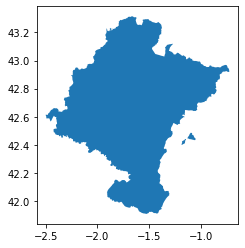

In [280]:
Navarra = gpd.read_file("../INE/REFERE_Pol_Navarra/REFERE_Pol_Navarra.shp")
Navarra = Navarra.to_crs("EPSG:4326")

Navarra.plot()

### Final data 

In [281]:
df = gpd.read_file('../Datasets/final_gdf.geojson')

pd.set_option('display.max_columns', None)
df.head()

df_without_navarra = gpd.overlay(df, Navarra, how='difference')

build_density = gpd.read_file('../builtdensity/builtdensity.shp')
build_density = build_density.drop(['rowid','id','nombre_cel','nombre_cel','p_pob_casa','p_pob_sale','pob_resid','OGC_FID','m.celda_or','pob_casa','pob_sale','pk'], axis = 1)
build_density = build_density.dropna()
build_density.head()

,srf_tot,srf_housin,geometry
1,2808866.0,2067231.0,"POLYGON ((2.15903 41.50740, 2.15904 41.50738, ..."
2,1710586.0,565717.0,"MULTIPOLYGON (((1.16553 41.13831, 1.16277 41.1..."
3,2117162.0,1748717.0,"POLYGON ((-15.64948 28.16497, -15.64937 28.164..."
4,3160944.0,1144317.0,"POLYGON ((-15.66313 27.91201, -15.66324 27.911..."
5,2198805.0,1574528.0,"POLYGON ((-0.38336 39.57589, -0.38336 39.57589..."


In [282]:
build_density.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [283]:
build_density = build_density.to_crs(epsg = 3035)
build_density['centroid'] =  build_density['geometry'].centroid
build_density = build_density.drop(['geometry'],axis=1)
build_density = gpd.GeoDataFrame(build_density, crs="EPSG:4326", geometry= 'centroid')
build_density = build_density.to_crs(epsg = 4326)

In [284]:
ultimate_move_df = gpd.sjoin(df_without_navarra, build_density, how="inner", op='intersects')
ultimate_move_df = ultimate_move_df.drop(['index_right'], axis = 1)
ultimate_move_df = ultimate_move_df.groupby('name_celda').mean()
ultimate_move_df = ultimate_move_df.merge(df_without_navarra[['name_celda','geometry']], left_index = True , right_on = 'name_celda')
ultimate_move_df = gpd.GeoDataFrame(ultimate_move_df, crs="EPSG:4326", geometry= 'geometry')

In [285]:
ultimate_move_df[ultimate_move_df.name_celda == 'Villanueva del Río Segura y otros municipios']

,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Income,srf_tot,srf_housin,name_celda,geometry
140,59953.53903,9.852849e+07,59953.53903,121.339378,8261.290612,7.377816,0.043316,0.014746,19.281143,25587.342136,2585,1325.0,1260.0,275.0,1750.0,560.0,1480.0,1025.0,110.0,350.0,5.0,55.0,30.0,50.0,255.0,230.0,155.0,110.0,65.0,55.0,9242.042553,1266007.5,575409.5,Villanueva del Río Segura y otros municipios,"POLYGON ((-1.23679 38.19827, -1.23672 38.18537..."


In [286]:
movements = gpd.read_file('../Datasets/movements.geojson')
nodes = movements.copy(deep = True)
nodes_l = nodes.drop([ 'nombre_celda_origen','celda_destino', 'celda_origen', 'flujo', 'n_destino', 'nombre_celda_destino', 'p_pob_casa','p_pob_sale', 'pob_resid', 'geometry'], axis = 1)
nodes_l['geometry'] = movements.geometry.boundary.explode()[:,0]
nodes_l = nodes_l.drop_duplicates()

In [287]:
ultimate_move_df = gpd.sjoin(ultimate_move_df, nodes_l, how="inner", op='intersects')
ultimate_move_df = ultimate_move_df.drop(['index_right'], axis = 1)

In [288]:
ultimate_move_df[ultimate_move_df.name_celda == 'Villanueva del Río Segura y otros municipios']

,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Income,srf_tot,srf_housin,name_celda,geometry,pob_casa,pob_sale
140,59953.53903,9.852849e+07,59953.53903,121.339378,8261.290612,7.377816,0.043316,0.014746,19.281143,25587.342136,2585,1325.0,1260.0,275.0,1750.0,560.0,1480.0,1025.0,110.0,350.0,5.0,55.0,30.0,50.0,255.0,230.0,155.0,110.0,65.0,55.0,9242.042553,1266007.5,575409.5,Villanueva del Río Segura y otros municipios,"POLYGON ((-1.23679 38.19827, -1.23672 38.18537...",3092,1573
140,59953.53903,9.852849e+07,59953.53903,121.339378,8261.290612,7.377816,0.043316,0.014746,19.281143,25587.342136,2585,1325.0,1260.0,275.0,1750.0,560.0,1480.0,1025.0,110.0,350.0,5.0,55.0,30.0,50.0,255.0,230.0,155.0,110.0,65.0,55.0,9242.042553,1266007.5,575409.5,Villanueva del Río Segura y otros municipios,"POLYGON ((-1.23679 38.19827, -1.23672 38.18537...",2954,1330


In [289]:
ultimate_move_df = ultimate_move_df.groupby('name_celda').mean()
ultimate_move_df = ultimate_move_df.merge(df_without_navarra[['name_celda','geometry']], left_index = True , right_on = 'name_celda')
ultimate_move_df = gpd.GeoDataFrame(ultimate_move_df, crs="EPSG:4326", geometry= 'geometry')

In [290]:
ultimate_move_df[ultimate_move_df.name_celda == 'Villanueva del Río Segura y otros municipios']

,shape_leng,shape__area,shape__length,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,tot_pop,Male,Female,sub_16_age,16_to_64_age,64_more_age,tot_house,first_home,second_home,vacation_home,less_30_m2,30_45_m2,46_60_m2,61_75_m2,76_90_m2,91_105_m2,106_120_m2,121_150_m2,150_180_m2,above_180_m2,Income,srf_tot,srf_housin,pob_casa,pob_sale,name_celda,geometry
140,59953.53903,9.852849e+07,59953.53903,121.339378,8261.290612,7.377816,0.043316,0.014746,19.281143,25587.342136,2585.0,1325.0,1260.0,275.0,1750.0,560.0,1480.0,1025.0,110.0,350.0,5.0,55.0,30.0,50.0,255.0,230.0,155.0,110.0,65.0,55.0,9242.042553,1266007.5,575409.5,3023.0,1451.5,Villanueva del Río Segura y otros municipios,"POLYGON ((-1.23679 38.19827, -1.23672 38.18537..."


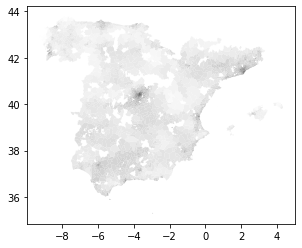

In [291]:
ultimate_move_df.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8)

#### Exporting the file

In [292]:
ultimate_move_df.to_file("../Datasets/ultimate_move_df.geojson", driver='GeoJSON')
ultimate_move_df.to_file("../Datasets/ultimate_move_df.shp")